#**Preprocessing Images Maize Dataset**

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime
import pytz
from time import time

import openpyxl
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.styles import Font, Alignment
import os
import sys

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from matplotlib import font_manager
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import psutil
import zipfile


import numpy as np
import tensorflow as tf
import random as rd

**Detail of Python Notebook in Google Colab**

In [ ]:
!nvidia-smi
import subprocess
print(f"Tensorflow version: {tf.__version__}")
print(f"Keras version: {tf.keras.__version__}")
print("-------------------------------------------------------------")
print(f"Python {sys.version}")
print("-------------------------------------------------------------")

# ตรวจสอบ GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("Running on GPU")
    strategy = tf.distribute.MirroredStrategy()
    print(f"Number of GPUs Available: {len(gpus)}")

    # ดึงข้อมูล GPU Memory
    try:
        result = subprocess.run(
            ['nvidia-smi', '--query-gpu=memory.total', '--format=csv,noheader,nounits'],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True
        )
        gpu_memory = result.stdout.strip().split('\n')
        for idx, mem in enumerate(gpu_memory):
            print(f"GPU {idx}: Total Memory: {int(mem) / 1024:.2f} GB")
    except FileNotFoundError:
        print("nvidia-smi is not available on this system.")
else:
    print("No GPU detected. Running on CPU")
    strategy = tf.distribute.get_strategy()

# แสดงจำนวนอุปกรณ์ที่พร้อมใช้งาน
print("Number of replicas:", strategy.num_replicas_in_sync)
print("-------------------------------------------------------------")

# แสดงจำนวน RAM ทั้งหมด
total_ram = psutil.virtual_memory().total / (1024 ** 3)
print(f"Total RAM of Colab instance: {total_ram:.2f} GB")
print("-------------------------------------------------------------")

# แสดงเวลาปัจจุบันในเขตเวลาไทย
thailand_tz = pytz.timezone('Asia/Bangkok')
current_time = datetime.now(thailand_tz).strftime("%Y-%m-%d %H:%M:%S")
print("Current Time (Thailand):", current_time)

Sun Aug 24 13:16:19 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

sys.path.append('/content/drive/MyDrive/projectPlant/Colab')
from my_model import *
from helper_functions import *

Mounted at /content/drive


**Initialize Setting**

In [ ]:
root_dir = '/content/drive/MyDrive/projectPlant/'

**SEED**

In [ ]:
seeds = [42]
print(seeds)

[42]


**Font Setting**

In [ ]:
locations = [f"{root_dir}Extra2/Font"]
font_files = font_manager.findSystemFonts(fontpaths=locations)
print(font_files[0])
for file in font_files:
  font_manager.fontManager.addfont(file)

/content/drive/MyDrive/projectPlant/Extra2/Font/OPTITimes-Roman.otf


**คำอธิบาย**

แบ่ง Data แบบ Fixed Train และ Validation ในอัตราส่วน 70:30

สำหรับ Test มี Dataset แยกอยู่แล้ว

In [ ]:
maize_title = 'Maize Dataset'
maize_dataset_name = 'maizeDataset'
maize_dataset_dir = root_dir + maize_dataset_name
selector = maize_dataset_name + '4Classes'

In [ ]:
maize_train_dir = maize_dataset_dir + '/train_smp'
maize_test_dir = maize_dataset_dir + '/pred_img'

In [ ]:
zip_filename = 'maize_dataset_raw.zip'
zip_dir = maize_dataset_dir + '/' + zip_filename
target_folders = [maize_train_dir, maize_test_dir]
with zipfile.ZipFile(zip_dir, "w", zipfile.ZIP_DEFLATED) as zipf:
    for folder in target_folders:
        for root, dirs, files in os.walk(folder):
            for file in files:
                file_path = os.path.join(root, file)
                zipf.write(file_path, os.path.relpath(file_path, os.path.dirname(folder)))
print(f'Zip folder complete at {zip_dir}')

Zip folder complete at /content/drive/MyDrive/projectPlant/maizeDataset/maize_dataset_raw.zip


In [ ]:
maize_img_dir = root_dir + 'Extra2/' + maize_dataset_name
maize_sample_img_dir = maize_img_dir + '/SampleImages'
maize_excel_dir = root_dir + 'DatasetSetting/' + maize_dataset_name + '/'

os.makedirs(maize_img_dir, exist_ok=True)
os.makedirs(maize_sample_img_dir, exist_ok=True)
os.makedirs(maize_excel_dir, exist_ok=True)

**Recheck Path and Verify Images**

In [ ]:
print("Total directories and maize train images: \n")
walk_through_dir(maize_train_dir)

Total directories and maize train images: 

There are 0 directories and 500 images in '/content/drive/MyDrive/projectPlant/maizeDataset/train_smp'.


In [ ]:
print("Total directories and maize test images: \n")
walk_through_dir(maize_test_dir)

Total directories and maize test images: 

There are 0 directories and 101 images in '/content/drive/MyDrive/projectPlant/maizeDataset/pred_img'.


In [ ]:
print("Verifying maize train images: \n")
verify_images(maize_train_dir)

Verifying maize train images: 

Checking: /content/drive/MyDrive/projectPlant/maizeDataset/train_smp/5_97.jpg Done
Checking: /content/drive/MyDrive/projectPlant/maizeDataset/train_smp/5_92.jpg Done
Checking: /content/drive/MyDrive/projectPlant/maizeDataset/train_smp/5_98.jpg Done
Checking: /content/drive/MyDrive/projectPlant/maizeDataset/train_smp/5_94.jpg Done
Checking: /content/drive/MyDrive/projectPlant/maizeDataset/train_smp/5_93.jpg Done
Checking: /content/drive/MyDrive/projectPlant/maizeDataset/train_smp/5_95.jpg Done
Checking: /content/drive/MyDrive/projectPlant/maizeDataset/train_smp/5_6.jpg Done
Checking: /content/drive/MyDrive/projectPlant/maizeDataset/train_smp/5_44.jpg Done
Checking: /content/drive/MyDrive/projectPlant/maizeDataset/train_smp/5_65.jpg Done
Checking: /content/drive/MyDrive/projectPlant/maizeDataset/train_smp/5_70.jpg Done
Checking: /content/drive/MyDrive/projectPlant/maizeDataset/train_smp/5_7.jpg Done
Checking: /content/drive/MyDrive/projectPlant/maizeDatase

In [ ]:
print("Verifying maize test images: \n")
verify_images(maize_test_dir)

Verifying maize test images: 

Checking: /content/drive/MyDrive/projectPlant/maizeDataset/pred_img/5_11.jpg Done
Checking: /content/drive/MyDrive/projectPlant/maizeDataset/pred_img/5_1.jpg Done
Checking: /content/drive/MyDrive/projectPlant/maizeDataset/pred_img/4_3.jpg Done
Checking: /content/drive/MyDrive/projectPlant/maizeDataset/pred_img/4_9.jpg Done
Checking: /content/drive/MyDrive/projectPlant/maizeDataset/pred_img/5_3.jpg Done
Checking: /content/drive/MyDrive/projectPlant/maizeDataset/pred_img/5_9.jpg Done
Checking: /content/drive/MyDrive/projectPlant/maizeDataset/pred_img/4_8.jpg Done
Checking: /content/drive/MyDrive/projectPlant/maizeDataset/pred_img/5_17.jpg Done
Checking: /content/drive/MyDrive/projectPlant/maizeDataset/pred_img/5_19.jpg Done
Checking: /content/drive/MyDrive/projectPlant/maizeDataset/pred_img/4_10.jpg Done
Checking: /content/drive/MyDrive/projectPlant/maizeDataset/pred_img/5_14.jpg Done
Checking: /content/drive/MyDrive/projectPlant/maizeDataset/pred_img/5_16.

**Match Label**

In [ ]:
labels_mapping = mapping(selector)
print(labels_mapping)

{'1': 'Phaeosphaeria spot', '2': 'Corn Eyespot', '3': 'Gray Leaf Spot', '4': "Goss's Bacterial wilt"}


**Convert to dataframe**

In [ ]:
base_maize_train_df = to_dataframe(maize_train_dir, mode='multi', condition=True, labels_mapping=labels_mapping)
base_maize_test_df = to_dataframe(maize_test_dir, mode='multi', condition=True, labels_mapping=labels_mapping)

Total images: 400
Total classes: 4
Total images: 81
Total classes: 4


In [ ]:
print("Base Maize Train Dataframe \n")
base_maize_train_df

Base Maize Train Dataframe 



,Filepath,Label
0,/content/drive/MyDrive/projectPlant/maizeDatas...,Goss's Bacterial wilt
1,/content/drive/MyDrive/projectPlant/maizeDatas...,Goss's Bacterial wilt
2,/content/drive/MyDrive/projectPlant/maizeDatas...,Goss's Bacterial wilt
3,/content/drive/MyDrive/projectPlant/maizeDatas...,Goss's Bacterial wilt
4,/content/drive/MyDrive/projectPlant/maizeDatas...,Goss's Bacterial wilt
...,...,...
395,/content/drive/MyDrive/projectPlant/maizeDatas...,Phaeosphaeria spot
396,/content/drive/MyDrive/projectPlant/maizeDatas...,Phaeosphaeria spot
397,/content/drive/MyDrive/projectPlant/maizeDatas...,Phaeosphaeria spot
398,/content/drive/MyDrive/projectPlant/maizeDatas...,Phaeosphaeria spot


In [ ]:
print("Base Maize Test Dataframe \n")
base_maize_test_df

Base Maize Test Dataframe 



,Filepath,Label
0,/content/drive/MyDrive/projectPlant/maizeDatas...,Goss's Bacterial wilt
1,/content/drive/MyDrive/projectPlant/maizeDatas...,Goss's Bacterial wilt
2,/content/drive/MyDrive/projectPlant/maizeDatas...,Goss's Bacterial wilt
3,/content/drive/MyDrive/projectPlant/maizeDatas...,Goss's Bacterial wilt
4,/content/drive/MyDrive/projectPlant/maizeDatas...,Goss's Bacterial wilt
...,...,...
76,/content/drive/MyDrive/projectPlant/maizeDatas...,Phaeosphaeria spot
77,/content/drive/MyDrive/projectPlant/maizeDatas...,Phaeosphaeria spot
78,/content/drive/MyDrive/projectPlant/maizeDatas...,Phaeosphaeria spot
79,/content/drive/MyDrive/projectPlant/maizeDatas...,Corn Eyespot


**Description table**

In [ ]:
maize_images_df = pd.concat([base_maize_train_df, base_maize_test_df], axis=0).reset_index(drop=True)
maize_images_df

,Filepath,Label
0,/content/drive/MyDrive/projectPlant/maizeDatas...,Goss's Bacterial wilt
1,/content/drive/MyDrive/projectPlant/maizeDatas...,Goss's Bacterial wilt
2,/content/drive/MyDrive/projectPlant/maizeDatas...,Goss's Bacterial wilt
3,/content/drive/MyDrive/projectPlant/maizeDatas...,Goss's Bacterial wilt
4,/content/drive/MyDrive/projectPlant/maizeDatas...,Goss's Bacterial wilt
...,...,...
476,/content/drive/MyDrive/projectPlant/maizeDatas...,Phaeosphaeria spot
477,/content/drive/MyDrive/projectPlant/maizeDatas...,Phaeosphaeria spot
478,/content/drive/MyDrive/projectPlant/maizeDatas...,Phaeosphaeria spot
479,/content/drive/MyDrive/projectPlant/maizeDatas...,Corn Eyespot


In [ ]:
print(f"{maize_title} description table \n")
maize_summary_df = maize_images_df.groupby('Label').size().reset_index(name='Count')
maize_summary_df

Maize Dataset description table 



,Label,Count
0,Corn Eyespot,121
1,Goss's Bacterial wilt,120
2,Gray Leaf Spot,121
3,Phaeosphaeria spot,119


##**Visualize Images**

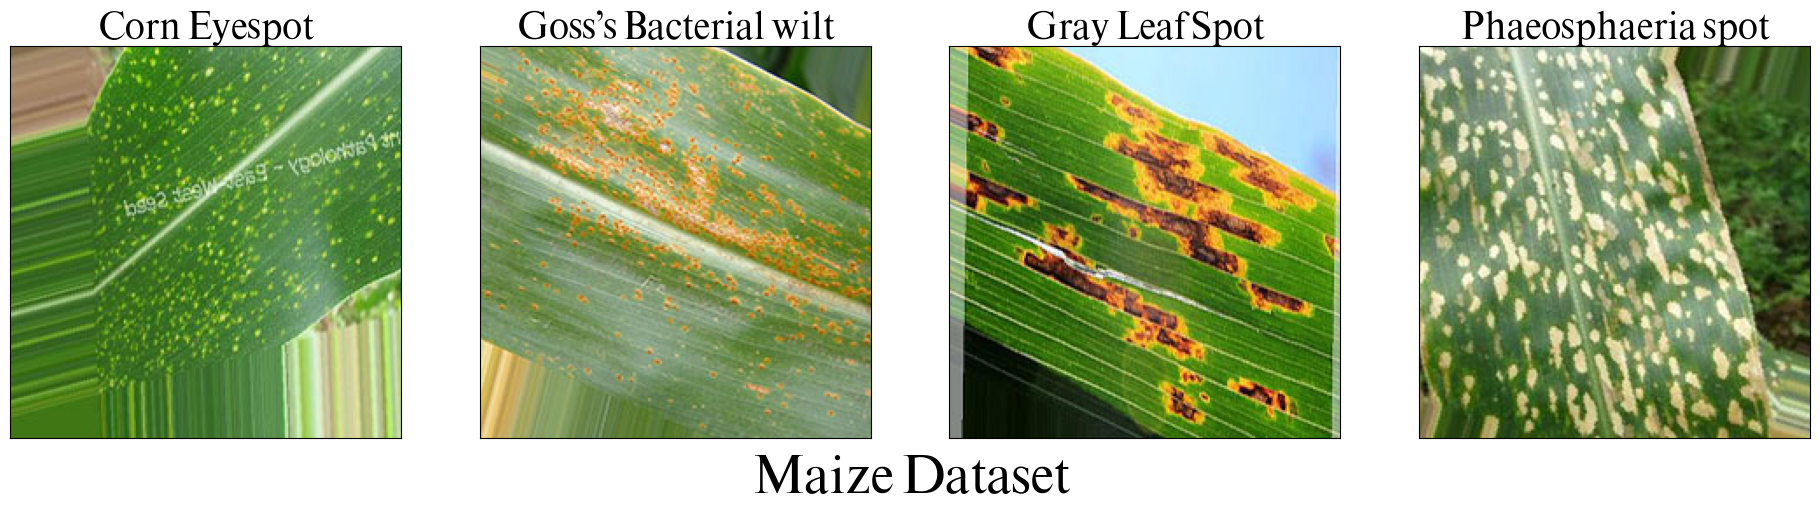

In [ ]:
visualize_images_by_class(df=maize_images_df, nrows=1, ncols=4, title=maize_title, fontsize=25,
                          fontname="OPTITimes-Roman", image_width=5, image_height=5, paths=maize_sample_img_dir)

##**Allocate Dataset**

In [ ]:
# วนลูปสำหรับแต่ละ SEED
for seed in seeds:
    print(f"Running experiment with SEED={seed}")
    np.random.seed(seed)
    tf.random.set_seed(seed)
    rd.seed(seed)

    # แบ่งข้อมูล Train (70%) และ Validation (30%)
    train_data, val_data = train_test_split(
        base_maize_train_df,
        test_size=0.3,  # 30% สำหรับ Validation
        random_state=seed
    )

    # เก็บ Original_Index
    train_data['Original_Index'] = train_data.index
    val_data['Original_Index'] = val_data.index

    # สร้าง DataFrame สำหรับ Train และ Validation
    data = {
        'Train_Index': train_data['Original_Index'].tolist(),
        'Train_Paths': train_data['Filepath'].tolist(),
        'Validation_Index': val_data['Original_Index'].tolist(),
        'Validation_Paths': val_data['Filepath'].tolist(),
    }

    # เติมข้อมูลให้มีความยาวเท่ากัน
    max_length = max(
        len(data['Train_Paths']),
        len(data['Validation_Paths'])
    )

    data['Train_Index'] += [''] * (max_length - len(data['Train_Index']))
    data['Train_Paths'] += [''] * (max_length - len(data['Train_Paths']))
    data['Validation_Index'] += [''] * (max_length - len(data['Validation_Index']))
    data['Validation_Paths'] += [''] * (max_length - len(data['Validation_Paths']))

    # แปลงข้อมูลเป็น DataFrame
    df = pd.DataFrame(data)

    # ตั้งชื่อไฟล์ที่บันทึก
    file_name = f'{maize_excel_dir}split_data_seed_{seed}.xlsx'

    # บันทึกข้อมูลลง Excel
    with pd.ExcelWriter(file_name, engine='openpyxl') as writer:
        df.to_excel(writer, index=False, sheet_name='Split-Data')

        # ปรับขนาดคอลัมน์
        workbook = writer.book
        sheet = workbook['Split-Data']

        for col in sheet.columns:
            max_length = 0
            column = col[0].column_letter  # Get the column letter
            for cell in col:
                try:
                    if len(str(cell.value)) > max_length:
                        max_length = len(str(cell.value))
                except:
                    pass
            adjusted_width = max_length + 2
            sheet.column_dimensions[column].width = adjusted_width

        # จัดรูปแบบ header
        header = sheet[1]
        for cell in header:
            cell.alignment = Alignment(horizontal="center", vertical="center")
            cell.font = Font(bold=True)

    print(f"Data split and saved to {file_name}")
    print("--------------------------------------------------")

Running experiment with SEED=42
Data split and saved to /content/drive/MyDrive/projectPlant/DatasetSetting/maizeDataset/split_data_seed_42.xlsx
--------------------------------------------------


##**Augmentation Samples Images**

In [ ]:
train_data

,Filepath,Label,Original_Index
157,/content/drive/MyDrive/projectPlant/maizeDatas...,Gray Leaf Spot,157
109,/content/drive/MyDrive/projectPlant/maizeDatas...,Gray Leaf Spot,109
17,/content/drive/MyDrive/projectPlant/maizeDatas...,Goss's Bacterial wilt,17
347,/content/drive/MyDrive/projectPlant/maizeDatas...,Phaeosphaeria spot,347
24,/content/drive/MyDrive/projectPlant/maizeDatas...,Goss's Bacterial wilt,24
...,...,...,...
71,/content/drive/MyDrive/projectPlant/maizeDatas...,Goss's Bacterial wilt,71
106,/content/drive/MyDrive/projectPlant/maizeDatas...,Gray Leaf Spot,106
270,/content/drive/MyDrive/projectPlant/maizeDatas...,Corn Eyespot,270
348,/content/drive/MyDrive/projectPlant/maizeDatas...,Phaeosphaeria spot,348


In [ ]:
val_data

,Filepath,Label,Original_Index
209,/content/drive/MyDrive/projectPlant/maizeDatas...,Corn Eyespot,209
280,/content/drive/MyDrive/projectPlant/maizeDatas...,Corn Eyespot,280
33,/content/drive/MyDrive/projectPlant/maizeDatas...,Goss's Bacterial wilt,33
210,/content/drive/MyDrive/projectPlant/maizeDatas...,Corn Eyespot,210
93,/content/drive/MyDrive/projectPlant/maizeDatas...,Gray Leaf Spot,93
...,...,...,...
60,/content/drive/MyDrive/projectPlant/maizeDatas...,Goss's Bacterial wilt,60
79,/content/drive/MyDrive/projectPlant/maizeDatas...,Goss's Bacterial wilt,79
285,/content/drive/MyDrive/projectPlant/maizeDatas...,Corn Eyespot,285
305,/content/drive/MyDrive/projectPlant/maizeDatas...,Phaeosphaeria spot,305


In [ ]:
SEED=seeds[-1]
np.random.seed(SEED)
tf.random.set_seed(SEED)
rd.seed(SEED)

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    brightness_range=[0.9, 1.1],
    fill_mode='nearest'
)

train_images = train_generator.flow_from_dataframe(
    dataframe = train_data,
    x_col = 'Filepath',
    y_col = 'Label',
    target_size = IMAGE_SIZE,
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = SEED
)

Found 280 validated image filenames belonging to 4 classes.


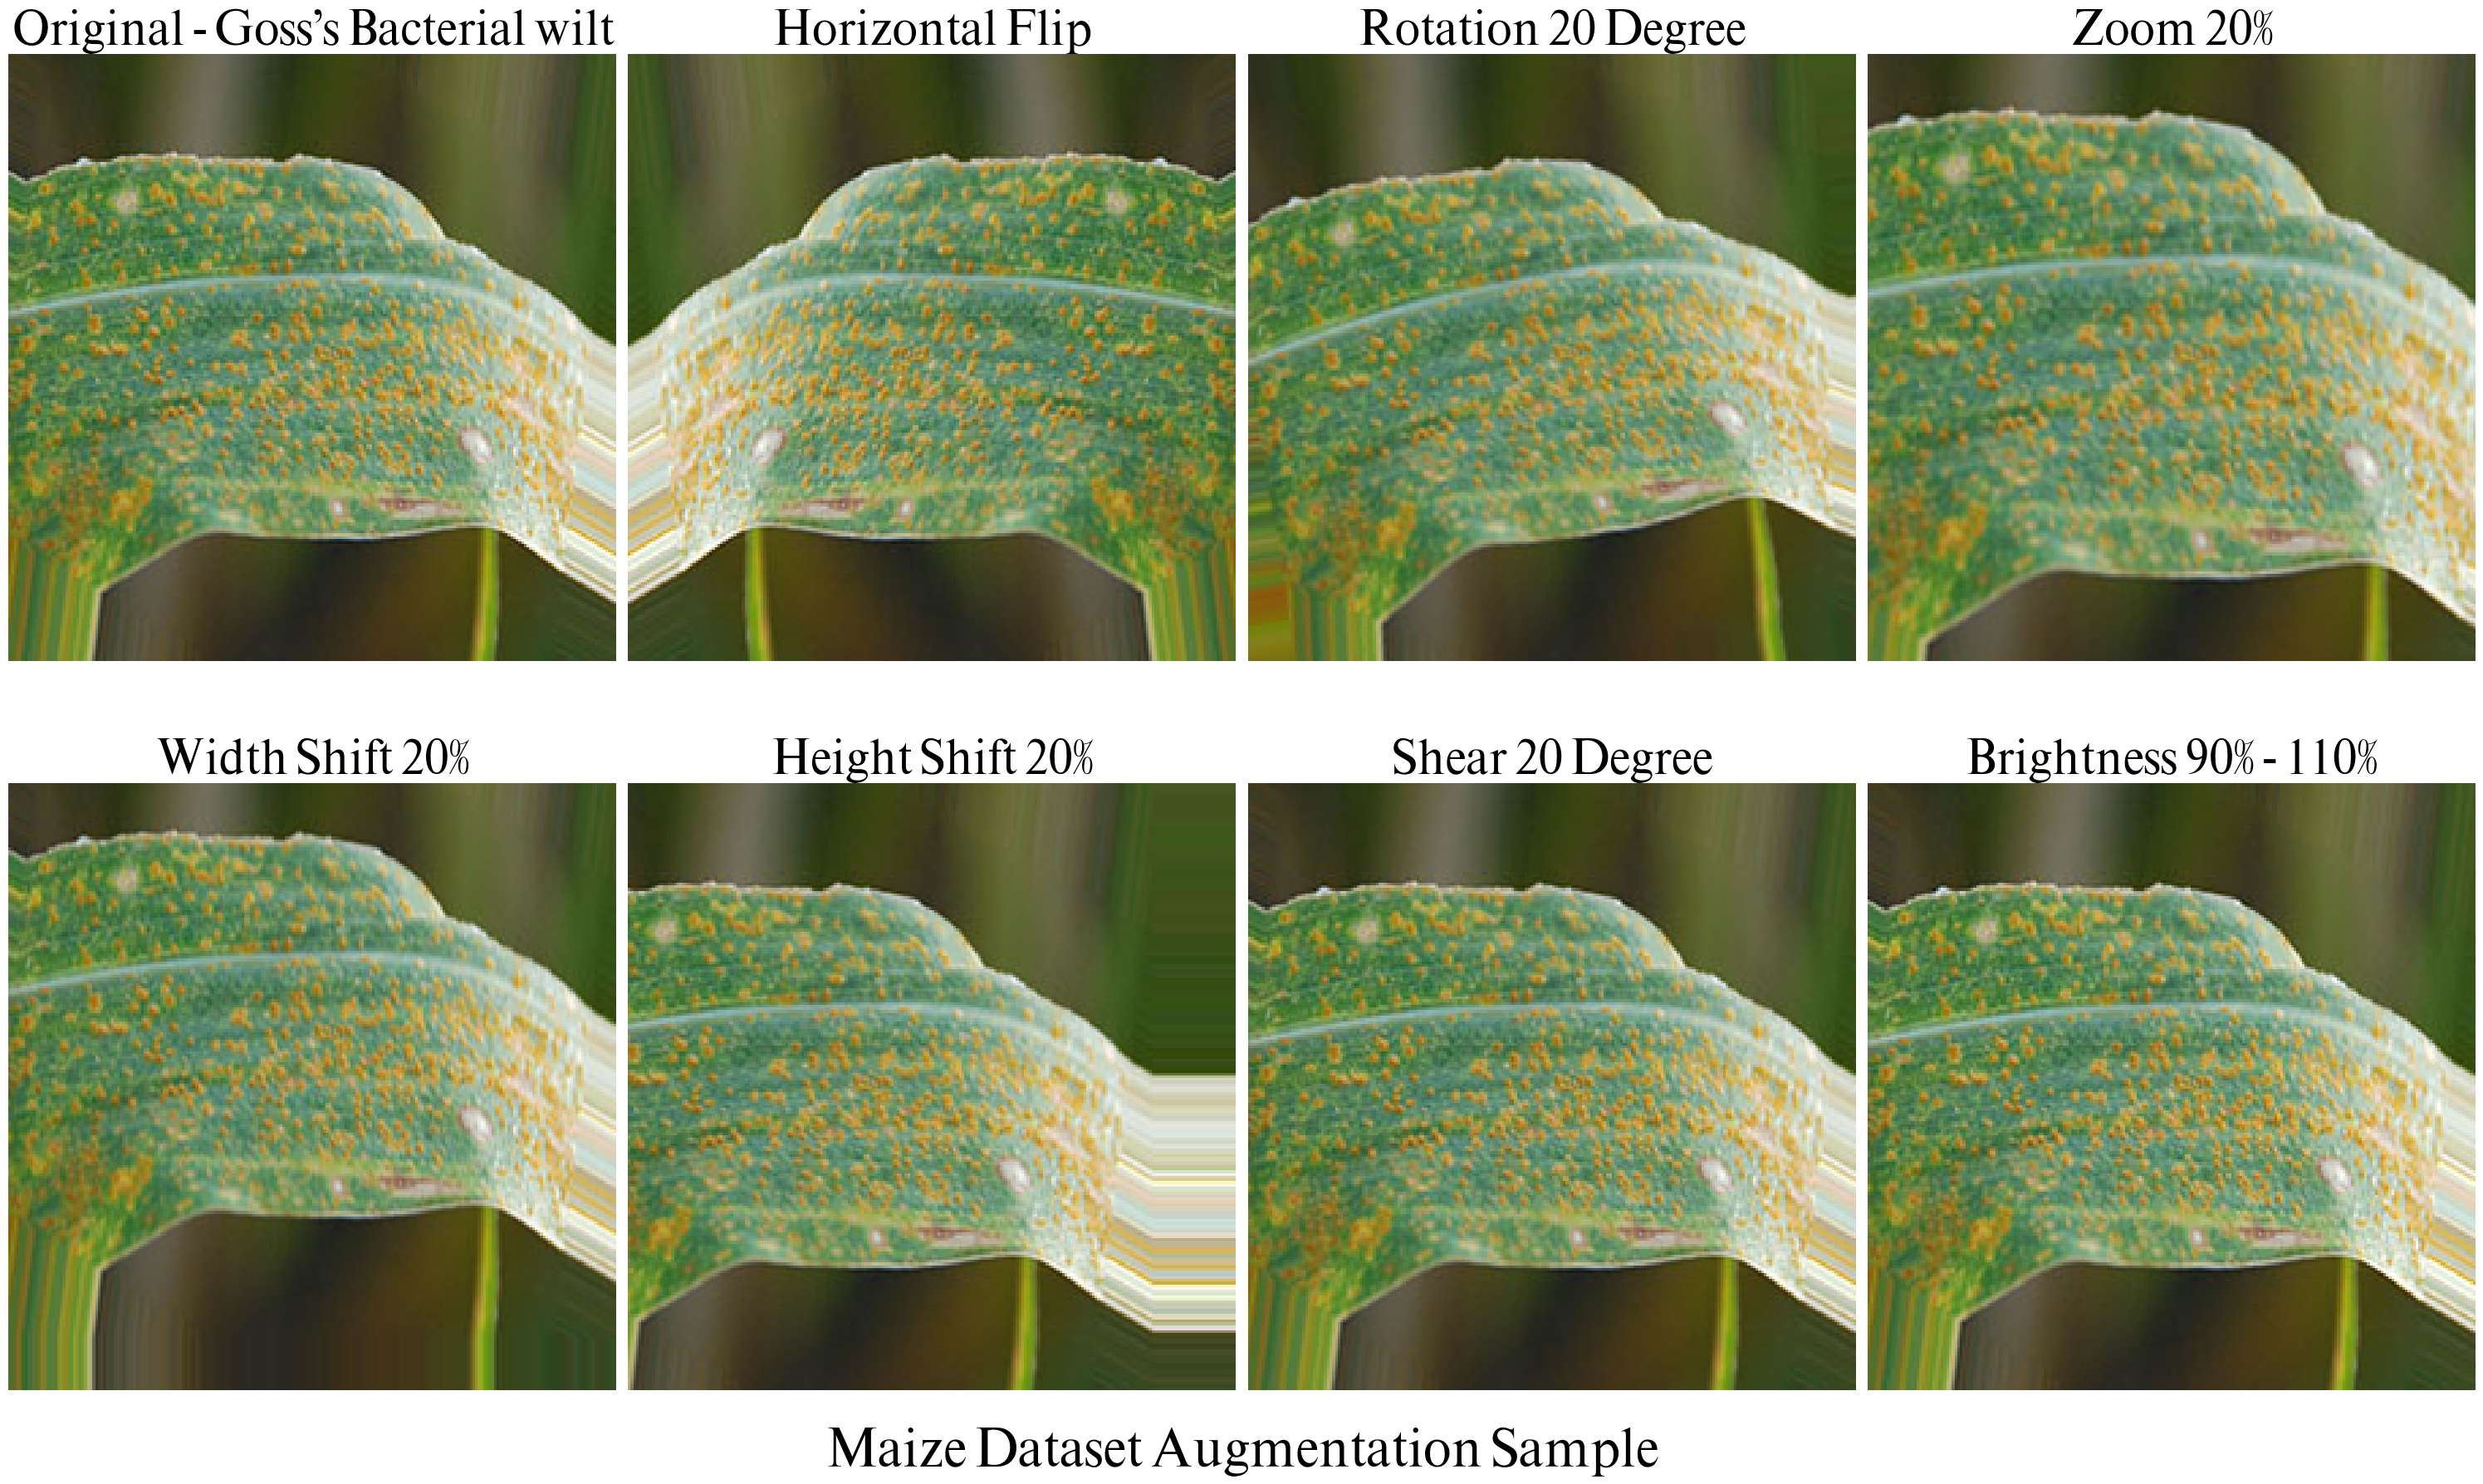

In [ ]:
preview_augmented_images(train_data, title=maize_title, index=2, paths=maize_sample_img_dir)

## **Summary of dataset**

**ส่วนที่รันเพิ่มเติม**

In [ ]:
TRAIN_DF, VALID_DF = to_dataframe_excel(path="/content/drive/MyDrive/projectPlant/DatasetSetting/maizeDataset/split_data_seed_42.xlsx", sheet_name='Split-Data', mode='multi', condition=False, labels_mapping=labels_mapping)

In [ ]:
TEST_DF = to_dataframe(maize_test_dir, mode='multi', condition=True, labels_mapping=labels_mapping)

Total images: 81
Total classes: 4


In [ ]:
combined_df = pd.concat([TRAIN_DF, VALID_DF, TEST_DF], axis=0).reset_index(drop=True)
combined_df = combined_df.drop(columns=['Original_Index'])
combined_df

,Filepath,Label
0,/content/drive/MyDrive/projectPlant/maizeDatas...,Gray Leaf Spot
1,/content/drive/MyDrive/projectPlant/maizeDatas...,Gray Leaf Spot
2,/content/drive/MyDrive/projectPlant/maizeDatas...,Goss's Bacterial wilt
3,/content/drive/MyDrive/projectPlant/maizeDatas...,Phaeosphaeria spot
4,/content/drive/MyDrive/projectPlant/maizeDatas...,Goss's Bacterial wilt
...,...,...
476,/content/drive/MyDrive/projectPlant/maizeDatas...,Phaeosphaeria spot
477,/content/drive/MyDrive/projectPlant/maizeDatas...,Phaeosphaeria spot
478,/content/drive/MyDrive/projectPlant/maizeDatas...,Phaeosphaeria spot
479,/content/drive/MyDrive/projectPlant/maizeDatas...,Corn Eyespot


In [ ]:
class_list = combined_df['Label'].unique().tolist()
print(class_list)

total_count = []
train_count = []
val_count = []
test_count = []

for class_name in class_list:
    total_count.append(len(combined_df[combined_df['Label'] == class_name]))
    train_count.append(len(TRAIN_DF[TRAIN_DF['Label'] == class_name]))
    val_count.append(len(VALID_DF[VALID_DF['Label'] == class_name]))
    test_count.append(len(TEST_DF[TEST_DF['Label'] == class_name]))

['Gray Leaf Spot', "Goss's Bacterial wilt", 'Phaeosphaeria spot', 'Corn Eyespot']


In [ ]:
summary_df = pd.DataFrame({
    'Class': class_list,
    'Dataset Count': total_count,
    'Train Count': train_count,
    'Validation Count': val_count,
    'Test Count': test_count
})
print(summary_df.to_string(index=False))

                Class  Dataset Count  Train Count  Validation Count  Test Count
       Gray Leaf Spot            121           76                24          21
Goss's Bacterial wilt            120           63                37          20
   Phaeosphaeria spot            119           73                27          19
         Corn Eyespot            121           68                32          21


In [ ]:
summary_df.to_excel(maize_excel_dir + 'summary_dataset.xlsx', index=False)